In [190]:
import os, sys, json, time, math, itertools, random, textwrap
from datetime import datetime, timedelta, date
from pathlib import Path

import numpy as np
import pandas as pd

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["axes.grid"] = True

# seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Load Datasets

In [191]:
# load the official dataset
visitation = pd.read_csv("data/VisitationData.csv")
climate = pd.read_csv("data/ClimdateData.csv")

In [192]:
# check the dataset info()
visitation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Year            165 non-null    float64
 1   Week            165 non-null    float64
 2   Mt. Baw Baw     165 non-null    float64
 3   Mt. Stirling    165 non-null    float64
 4   Mt. Hotham      165 non-null    float64
 5   Falls Creek     165 non-null    float64
 6   Mt. Buller      165 non-null    float64
 7   Selwyn          165 non-null    float64
 8   Thredbo         165 non-null    float64
 9   Perisher        165 non-null    float64
 10  Charlotte Pass  165 non-null    float64
dtypes: float64(11)
memory usage: 86.0 KB


In [193]:
climate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39813 entries, 0 to 39812
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Bureau of Meteorology station number  39813 non-null  int64  
 1   Year                                  39813 non-null  int64  
 2   Month                                 39813 non-null  int64  
 3   Day                                   39813 non-null  int64  
 4   Maximum temperature (Degree C)        38275 non-null  float64
 5   Minimum temperature (Degree C)        38280 non-null  float64
 6   Rainfall amount (millimetres)         37857 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 2.1 MB


In [194]:
# load external datasets like pricing, accessibility, special features
life_features = pd.read_csv("data/ticket_lift_fees.csv")
vic_snowfall = pd.read_csv("data/vic_snowfall.csv")
nsw_snowfall = pd.read_csv("data/nsw_snowfall.csv")
distance = pd.read_csv("data/ski_resorts_distances.csv")

In [195]:
life_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ski Resort     9 non-null      object 
 1   parking        9 non-null      int64  
 2   lift           9 non-null      int64  
 3   blue_slope     9 non-null      float64
 4   red_slope      9 non-null      float64
 5   black_slope    9 non-null      float64
 6   cross-country  9 non-null      bool   
dtypes: bool(1), float64(3), int64(2), object(1)
memory usage: 573.0+ bytes


In [196]:
vic_snowfall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Station                      424 non-null    int64  
 1   Date                         424 non-null    object 
 2   Day                          424 non-null    object 
 3   Average_snow_deepth_10years  424 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 13.4+ KB


In [197]:
nsw_snowfall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Station                      33 non-null     int64  
 1   Season                       33 non-null     object 
 2   Total Snowfall (inches)      33 non-null     int64  
 3   Snowfall Days                33 non-null     int64  
 4   Average Base Depth (inches)  28 non-null     float64
 5   Max Base Depth (inches)      28 non-null     float64
 6   Biggest Snowfall (inches)    33 non-null     int64  
 7   Total Snowfall (cm)          33 non-null     float64
 8   Average Base Depth (cm)      28 non-null     float64
 9   Max Base Depth (cm)          28 non-null     float64
 10  Biggest Snowfall (cm)        33 non-null     float64
dtypes: float64(6), int64(4), object(1)
memory usage: 3.0+ KB


In [198]:
distance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ski Resort         9 non-null      object 
 1   State              9 non-null      object 
 2   Distance_from_MEL  9 non-null      object 
 3   Distance_from_SYD  9 non-null      object 
 4   Distance_from_CAN  9 non-null      object 
 5   Time_from_MEL      9 non-null      float64
 6   Time_from_SYD      9 non-null      float64
 7   Time_from_CAN      9 non-null      float64
 8   Public Transport   9 non-null      object 
dtypes: float64(3), object(6)
memory usage: 780.0+ bytes


# Data Cleaning

In [199]:
# ---- CONFIG / CONSTANTS ----
SEED = 42

RESORT_TO_STATION = {
    "Thredbo":         71032,  # Thredbo AWS
    "Perisher":        71075,  # Perisher AWS
    "Selwyn":          72161,  # Cabramurra SMHEA AWS (closest for Selwyn)
    "Charlotte Pass":  71075,  # often use Perisher AWS; change if you prefer 72161
    "Mt. Buller":      83024,  # Mount Buller
    "Falls Creek":     83084,  # Falls Creek
    "Mt. Hotham":      83085,  # Mount Hotham
    "Mt. Baw Baw":     85291,  # Mount Baw Baw
    "Mt. Stirling":    83024,  # share with Buller (no dedicated BoM AWS)
}

# Standard resort name canonicalization (match across all frames)
RESORT_CANON = {
    "Mt. Baw Baw": "Mt. Baw Baw",
    "Mt. Stirling": "Mt. Stirling",
    "Mt. Hotham": "Mt. Hotham",
    "Falls Creek": "Falls Creek",
    "Mt. Buller": "Mt. Buller",
    "Selwyn": "Selwyn",
    "Thredbo": "Thredbo",
    "Perisher": "Perisher",
    "Charlotte Pass": "Charlotte Pass",
}

In [200]:
# your start / end (month, day only)
start_month, start_day = 6, 9
end_month, end_day     = 9, 22

# build a datetime for easy comparisons (any year)
climate["date"] = pd.to_datetime(climate[["Year","Month","Day"]])

def in_range(row, start_m, start_d, end_m, end_d):
    # build dates for that specific year
    year = row["Year"]
    start = pd.Timestamp(year=year, month=start_m, day=start_d)
    end   = pd.Timestamp(year=year, month=end_m,   day=end_d)
    return start <= row["date"] <= end

climate_clean = climate[climate.apply(in_range, axis=1,
                                      args=(start_month, start_day, end_month, end_day))]
climate_clean = climate_clean[climate_clean["Year"]>=2014]
climate_clean.to_csv("intermediate/climate_snowseason.csv")

### Week keys and Distance Parsing

In [201]:
# Week key from pandas Timestamp
def _week_key_from_date(dt):
    iso = dt.isocalendar()
    return int(iso.year), int(iso.week)

# Parse strings like "383 km / 4h50m" -> (383.0, 290.0)
def _parse_km_time(cell):
    if pd.isna(cell): 
        return np.nan, np.nan
    s = str(cell)
    try:
        km_part, time_part = [x.strip() for x in s.split('/')]
        km = float(km_part.lower().replace('km','').strip())
        t = time_part.lower().replace(' ', '')
        h = 0; m = 0
        if 'h' in t:
            h_str = t.split('h')[0]
            h = int(''.join(filter(str.isdigit, h_str))) if h_str else 0
            t = t.split('h',1)[1]
        if 'm' in t:
            m_str = t.split('m')[0]
            m = int(''.join(filter(str.isdigit, m_str))) if m_str else 0
        minutes = h*60 + m
        km = float(km)
        return km, float(minutes)
    except Exception:
        return np.nan, np.nan


In [202]:
vis_df = visitation.copy()

# keep valid year/week
vis_df = vis_df.dropna(subset=["Year","Week"]).copy()
vis_df["Year"] = vis_df["Year"].astype(int)
vis_df["Week"] = vis_df["Week"].astype(int)

resort_cols = [c for c in vis_df.columns if c not in ["Year","Week"]]
vis_long = vis_df.melt(id_vars=["Year","Week"], value_vars=resort_cols,
                       var_name="Ski Resort", value_name="visitors")
vis_long["Ski Resort"] = vis_long["Ski Resort"].map(RESORT_CANON).fillna(vis_long["Ski Resort"])
vis_long = vis_long.dropna(subset=["visitors"]).reset_index(drop=True)

vis_long.head()

,Year,Week,Ski Resort,visitors
0,2014,1,Mt. Baw Baw,555.0
1,2014,2,Mt. Baw Baw,804.0
2,2014,3,Mt. Baw Baw,993.0
3,2014,4,Mt. Baw Baw,2976.0
4,2014,5,Mt. Baw Baw,11112.0


In [203]:
cl = climate_clean.copy()
cl["date"] = pd.to_datetime(cl[["Year","Month","Day"]], errors="coerce")

# Week 1 = Jun 9; every 7 days a new week; cap at 15; filter to Jun 9 .. Sep 15 inclusive
season_start = pd.to_datetime({"year": cl["Year"].astype(int), "month": 6, "day": 9})
season_end   = pd.to_datetime({"year": cl["Year"].astype(int), "month": 9, "day": 15})
delta_days   = (cl["date"] - season_start).dt.days

cl = cl[(cl["date"] >= season_start) & (cl["date"] <= season_end)].copy()
cl["Week"] = ((delta_days // 7) + 1).clip(lower=1, upper=15).astype(int)

# standardize column names
cl = cl.rename(columns={
    "Bureau of Meteorology station number": "station_id",
    "Maximum temperature (Degree C)": "TempMax_C",
    "Minimum temperature (Degree C)": "TempMin_C",
    "Rainfall amount (millimetres)": "Rain_mm",
})

# weekly climate by station
climate_weekly_by_station = (
    cl.groupby(["Year","Week","station_id"], as_index=False)
      .agg({"TempMax_C":"mean", "TempMin_C":"mean", "Rain_mm":"sum"})
)

In [204]:
# --- VIC snowfall weekly aggregation (10-year averages) ---

sf = vic_snowfall.copy()

# 0) Parse '9-Jun' style dates by appending a dummy year
BASE_YEAR = 2014
sf["date"] = pd.to_datetime(
    sf["Date"].astype(str).str.strip() + f"-{BASE_YEAR}",
    format="%d-%b-%Y",   # use "%d-%B-%Y" if months are full names like 'June'
    errors="coerce"
)

# 1) Season weeks relative to Jun-09 (same BASE_YEAR)
season_start = pd.Timestamp(BASE_YEAR, 6, 9)
season_end   = pd.Timestamp(BASE_YEAR, 9, 30)  # wide enough to include your last rows

sf = sf.loc[(sf["date"] >= season_start) & (sf["date"] <= season_end)].copy()
sf["Week"] = ((sf["date"] - season_start).dt.days // 7 + 1).clip(1, 15).astype(int)

# 2) Standardize columns / dtypes
sf = sf.rename(columns={"Station": "station_id"})
sf["station_id"] = pd.to_numeric(sf["station_id"], errors="coerce").astype("Int64")
sf["Average_snow_deepth_10years"] = pd.to_numeric(sf["Average_snow_deepth_10years"], errors="coerce")

# 3) Weekly snow depth (10-year avg) per station (no Year dimension)
snowfall_weekly_by_station = (
    sf.groupby(["Week", "station_id"], as_index=False)["Average_snow_deepth_10years"].mean()
)

# 4) Merge into climate table for every Year (repeat the weekly pattern each year)
climate = climate_weekly_by_station.copy()
climate["station_id"] = pd.to_numeric(climate["station_id"], errors="coerce").astype("Int64")
climate["Year"] = climate["Year"].astype(int)
climate["Week"] = climate["Week"].astype(int)

climate = climate.merge(
    snowfall_weekly_by_station,
    on=["Week", "station_id"],
    how="left"
)

# 5) Optional: smooth with a 3-week rolling avg within each Year & station
climate = (climate
    .sort_values(["station_id", "Year", "Week"])
    .assign(
        SnowAvgDepth_cm_roll3=lambda d:
            d.groupby(["station_id", "Year"])["Average_snow_deepth_10years"]
             .transform(lambda s: s.rolling(3, min_periods=1).mean())
    )
)

display(climate)


,Year,Week,station_id,TempMax_C,TempMin_C,Rain_mm,Average_snow_deepth_10years,SnowAvgDepth_cm_roll3
0,2014,1,71032,4.714286,-2.000000,40.6,NaN,NaN
7,2014,2,71032,2.657143,-1.685714,8.0,NaN,NaN
14,2014,3,71032,-1.028571,-4.114286,4.2,NaN,NaN
21,2014,4,71032,-1.314286,-4.357143,0.4,NaN,NaN
28,2014,5,71032,-1.685714,-5.185714,3.0,NaN,NaN
...,...,...,...,...,...,...,...,...
1182,2025,4,85291,4.328571,-0.485714,131.6,23.385714,18.395238
1189,2025,5,85291,2.014286,-1.457143,63.2,25.114286,22.695238
1196,2025,6,85291,1.542857,-2.214286,19.8,36.171429,28.223810
1203,2025,7,85291,2.328571,-1.457143,33.4,42.842857,34.709524


In [205]:
# --- Step 1: VIC weekly merge (same as you already do) ---
sf = vic_snowfall.copy()
BASE_YEAR = 2014
sf["date"] = pd.to_datetime(
    sf["Date"].astype(str).str.strip() + f"-{BASE_YEAR}",
    format="%d-%b-%Y", errors="coerce"
)

season_start = pd.Timestamp(BASE_YEAR, 6, 9)
season_end   = pd.Timestamp(BASE_YEAR, 9, 30)

sf = sf.loc[(sf["date"] >= season_start) & (sf["date"] <= season_end)].copy()
sf["Week"] = ((sf["date"] - season_start).dt.days // 7 + 1).clip(1, 15).astype(int)

sf = sf.rename(columns={"Station": "station_id"})
sf["station_id"] = pd.to_numeric(sf["station_id"], errors="coerce").astype("Int64")
sf["Average_snow_deepth_10years"] = pd.to_numeric(sf["Average_snow_deepth_10years"], errors="coerce")

snowfall_weekly_by_station = (
    sf.groupby(["Week","station_id"], as_index=False)["Average_snow_deepth_10years"].mean()
)

climate = climate_weekly_by_station.copy()
climate["station_id"] = pd.to_numeric(climate["station_id"], errors="coerce").astype("Int64")
climate["Year"] = climate["Year"].astype(int)
climate["Week"] = climate["Week"].astype(int)

climate = climate.merge(snowfall_weekly_by_station, on=["Week","station_id"], how="left")

# --- Step 2: NSW season-level merge ---
nsw = nsw_snowfall.copy()
nsw = nsw.rename(columns={"Average Base Depth (cm)": "AvgBaseDepth_cm",
                          "Station": "station_id"})
nsw["station_id"] = pd.to_numeric(nsw["station_id"], errors="coerce").astype("Int64")

import re
def season_to_year(s):
    m = re.search(r"(\d{4})", str(s))
    return int(m.group(1)) if m else None

nsw["Year"] = nsw["Season"].apply(season_to_year).astype("Int64")
nsw_yearly = nsw.groupby(["Year","station_id"], as_index=False)["AvgBaseDepth_cm"].mean()

# merge on Year+station_id (fills NSW resorts, all weeks same value)
climate = climate.merge(nsw_yearly, on=["Year","station_id"], how="left")

# --- Step 3: Combine VIC + NSW into one column ---
if "Average_snow_deepth_10years" not in climate.columns:
    climate["Average_snow_deepth_10years"] = pd.NA

climate["Average_snow_deepth_10years"] = climate["Average_snow_deepth_10years"].fillna(
    climate["AvgBaseDepth_cm"]
)

climate = climate.drop(columns=["AvgBaseDepth_cm"])

# --- Step 4: Rolling average within station/year ---
climate = (
    climate.sort_values(["station_id","Year","Week"])
           .assign(
               SnowAvgDepth_cm_roll3=lambda d:
                   d.groupby(["station_id","Year"])["Average_snow_deepth_10years"]
                    .transform(lambda s: s.rolling(3,min_periods=1).mean())
           )
)

display(climate)


,Year,Week,station_id,TempMax_C,TempMin_C,Rain_mm,Average_snow_deepth_10years,SnowAvgDepth_cm_roll3
0,2014,1,71032,4.714286,-2.000000,40.6,132.080000,132.080000
7,2014,2,71032,2.657143,-1.685714,8.0,132.080000,132.080000
14,2014,3,71032,-1.028571,-4.114286,4.2,132.080000,132.080000
21,2014,4,71032,-1.314286,-4.357143,0.4,132.080000,132.080000
28,2014,5,71032,-1.685714,-5.185714,3.0,132.080000,132.080000
...,...,...,...,...,...,...,...,...
1182,2025,4,85291,4.328571,-0.485714,131.6,23.385714,18.395238
1189,2025,5,85291,2.014286,-1.457143,63.2,25.114286,22.695238
1196,2025,6,85291,1.542857,-2.214286,19.8,36.171429,28.223810
1203,2025,7,85291,2.328571,-1.457143,33.4,42.842857,34.709524


In [206]:
feat_df = pd.read_csv("data/ticket_lift_fees.csv")
df = feat_df
df["Ski Resort"] = df["Ski Resort"].map(RESORT_CANON).fillna(df["Ski Resort"])

num_cols = ["parking", "lift", "blue_slope", "red_slope", "black_slope"]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df.dtypes

Ski Resort        object
parking            int64
lift               int64
blue_slope       float64
red_slope        float64
black_slope      float64
cross-country       bool
dtype: object

In [207]:
# Convert cross-country column ---
if "cross-country" in df.columns:
    df["cross_country"] = df["cross-country"].astype(bool).astype(int)
    df = df.drop(columns=["cross-country"])
df.head()


,Ski Resort,parking,lift,blue_slope,red_slope,black_slope,cross_country
0,Falls Creek,67,243,6.0,35.0,8.0,0
1,Mount Buller,67,234,9.5,21.4,16.6,0
2,Mount Hotham,67,243,6.0,12.0,12.0,0
3,Mount Baw Baw,67,89,7.0,3.0,0.0,0
4,Mount Stirling,67,0,0.0,0.0,0.0,1


In [208]:
# --- Cell 1: Start with a copy & canonicalize resort names ---
df = distance.copy()

# assumes RESORT_CANON is a dict like {"Mt. Hotham":"Mount Hotham", ...}
if "Ski Resort" in df.columns:
    df["Ski Resort"] = df["Ski Resort"].map(RESORT_CANON).fillna(df["Ski Resort"])

df.head()


,Ski Resort,State,Distance_from_MEL,Distance_from_SYD,Distance_from_CAN,Time_from_MEL,Time_from_SYD,Time_from_CAN,Public Transport
0,Falls Creek,VIC,383 km,672 km,462 km,4.83,7.87,5.62,SnowBus
1,Mount Buller,VIC,234 km,771 km,561 km,3.25,8.37,6.12,Coach
2,Mount Hotham,VIC,373 km,702 km,493 km,4.62,8.07,5.82,SnowBus
3,Mount Baw Baw,VIC,176 km,914 km,639 km,2.83,10.83,7.73,Train
4,Mount Stirling,VIC,236 km,775 km,566 km,3.72,8.78,6.53,Coach


In [209]:
# --- Cell 2: Helper parser for "383 km / 4h50m" → (383.0, 290) ---
import re

def _km_minutes_from_text(s: str):
    if s is None:
        return (None, None)
    s = str(s)

    # km
    km_match = re.search(r'(\d+(?:\.\d+)?)\s*km', s, flags=re.I)
    km = float(km_match.group(1)) if km_match else None

    # time: supports "4h50m", "4 h 50 m", "4h", "50m"
    h = m = 0
    h_match = re.search(r'(\d+)\s*h', s, flags=re.I)
    m_match = re.search(r'(\d+)\s*m', s, flags=re.I)
    if h_match:
        h = int(h_match.group(1))
    if m_match:
        m = int(m_match.group(1))
    minutes = h * 60 + m if (h or m) else None

    return (km, minutes)


In [210]:
def clean_distances(dist_df):
    """Parse distance/time strings; derive travel metrics; tidy public transport."""
    df = dist_df.copy()
    df["Ski Resort"] = df["Ski Resort"].map(RESORT_CANON).fillna(df["Ski Resort"])

    # Parse distance/time from MEL/SYD/CAN
    for city in ["MEL","SYD","CAN"]:
        km_col = f"Distance_{city}_km"
        vals = df[f"Distance_from_{city}"].apply(parse_km_time)
        df[km_col]  = [v[0] for v in vals]

    # Public transport → boolean/categorical
    if "Public Transport" in df.columns:
        df["public_transport"] = df["Public Transport"].astype(str).str.strip().str.lower()
        df["has_public_transport"] = df["public_transport"].isin(["yes","y","available","true"]).astype(int)

    keep = ["Ski Resort","State",
            "Distance_MEL_km","Distance_SYD_km","Distance_CAN_km"
            ,"has_public_transport"]
    return df[[c for c in keep if c in df.columns]].copy()

In [211]:
# --- Cell 3: Parse the distance/time fields for MEL / SYD / CAN (only if present) ---
for city in ["MEL", "SYD", "CAN"]:
    src_col = f"Distance_from_{city}"
    if src_col in df.columns:
        parsed = df[src_col].apply(_km_minutes_from_text)
        df[f"Distance_{city}_km"]  = [p[0] for p in parsed]

df.head()


,Ski Resort,State,Distance_from_MEL,Distance_from_SYD,Distance_from_CAN,Time_from_MEL,Time_from_SYD,Time_from_CAN,Public Transport,Distance_MEL_km,Distance_SYD_km,Distance_CAN_km
0,Falls Creek,VIC,383 km,672 km,462 km,4.83,7.87,5.62,SnowBus,383.0,672.0,462.0
1,Mount Buller,VIC,234 km,771 km,561 km,3.25,8.37,6.12,Coach,234.0,771.0,561.0
2,Mount Hotham,VIC,373 km,702 km,493 km,4.62,8.07,5.82,SnowBus,373.0,702.0,493.0
3,Mount Baw Baw,VIC,176 km,914 km,639 km,2.83,10.83,7.73,Train,176.0,914.0,639.0
4,Mount Stirling,VIC,236 km,775 km,566 km,3.72,8.78,6.53,Coach,236.0,775.0,566.0


In [212]:
# --- Cell 4: Public transport standardization ---
if "Public Transport" in df.columns:
    pt = df["Public Transport"].astype(str).str.strip().str.lower()
    yes_tokens = {"yes", "y", "available", "true", "1"}
    df["public_transport"] = pt
    df["has_public_transport"] = pt.isin(yes_tokens).astype(int)
elif "has_public_transport" not in df.columns:
    # ensure the column exists even if source column missing
    df["has_public_transport"] = 0

df.head()


,Ski Resort,State,Distance_from_MEL,Distance_from_SYD,Distance_from_CAN,Time_from_MEL,Time_from_SYD,Time_from_CAN,Public Transport,Distance_MEL_km,Distance_SYD_km,Distance_CAN_km,public_transport,has_public_transport
0,Falls Creek,VIC,383 km,672 km,462 km,4.83,7.87,5.62,SnowBus,383.0,672.0,462.0,snowbus,0
1,Mount Buller,VIC,234 km,771 km,561 km,3.25,8.37,6.12,Coach,234.0,771.0,561.0,coach,0
2,Mount Hotham,VIC,373 km,702 km,493 km,4.62,8.07,5.82,SnowBus,373.0,702.0,493.0,snowbus,0
3,Mount Baw Baw,VIC,176 km,914 km,639 km,2.83,10.83,7.73,Train,176.0,914.0,639.0,train,0
4,Mount Stirling,VIC,236 km,775 km,566 km,3.72,8.78,6.53,Coach,236.0,775.0,566.0,coach,0


In [213]:
# --- Cell 5: Keep tidy columns that exist ---
keep = [
    "Ski Resort", "State",
    "Distance_MEL_km", "Distance_SYD_km", "Distance_CAN_km",
    "Time_from_MEL","Time_from_SYD","Time_from_CAN",
    "has_public_transport"
]
cleaned_dist = df[[c for c in keep if c in df.columns]].copy()
cleaned_dist.head()


,Ski Resort,State,Distance_MEL_km,Distance_SYD_km,Distance_CAN_km,Time_from_MEL,Time_from_SYD,Time_from_CAN,has_public_transport
0,Falls Creek,VIC,383.0,672.0,462.0,4.83,7.87,5.62,0
1,Mount Buller,VIC,234.0,771.0,561.0,3.25,8.37,6.12,0
2,Mount Hotham,VIC,373.0,702.0,493.0,4.62,8.07,5.82,0
3,Mount Baw Baw,VIC,176.0,914.0,639.0,2.83,10.83,7.73,0
4,Mount Stirling,VIC,236.0,775.0,566.0,3.72,8.78,6.53,0


# Feature Engineering

In [214]:
clim = climate.copy()

# === Basic temperature features ===
clim["TempMean_C"] = (clim["TempMax_C"] + clim["TempMin_C"]) / 2
clim["DiurnalRange_C"] = clim["TempMax_C"] - clim["TempMin_C"]

# Freezing-related indicators
clim["Freeze_flag"] = (clim["TempMin_C"] <= 0).astype(int)
clim["Cold_degree"] = (0 - clim["TempMean_C"]).clip(lower=0)  # how far below 0 °C

# Rainfall transforms
clim["Rain_log1p"] = np.log1p(clim["Rain_mm"].clip(lower=0))
clim["Rain_heavy"] = (clim["Rain_mm"] >= 20).astype(int)

# Interactions
clim["Cold_x_Rain"] = clim["Cold_degree"] * clim["Rain_log1p"]

# Snow depth transforms
clim["SnowDepth_cm"] = clim["Average_snow_deepth_10years"].fillna(clim["SnowAvgDepth_cm_roll3"])
clim["SnowDepth_log1p"] = np.log1p(clim["SnowDepth_cm"].clip(lower=0))

clim.head()


,Year,Week,station_id,TempMax_C,TempMin_C,Rain_mm,Average_snow_deepth_10years,SnowAvgDepth_cm_roll3,TempMean_C,DiurnalRange_C,Freeze_flag,Cold_degree,Rain_log1p,Rain_heavy,Cold_x_Rain,SnowDepth_cm,SnowDepth_log1p
0,2014,1,71032,4.714286,-2.000000,40.6,132.08,132.08,1.357143,6.714286,1,0.000000,3.728100,1,0.000000,132.08,4.89095
7,2014,2,71032,2.657143,-1.685714,8.0,132.08,132.08,0.485714,4.342857,1,0.000000,2.197225,0,0.000000,132.08,4.89095
14,2014,3,71032,-1.028571,-4.114286,4.2,132.08,132.08,-2.571429,3.085714,1,2.571429,1.648659,0,4.239408,132.08,4.89095
21,2014,4,71032,-1.314286,-4.357143,0.4,132.08,132.08,-2.835714,3.042857,1,2.835714,0.336472,0,0.954139,132.08,4.89095
28,2014,5,71032,-1.685714,-5.185714,3.0,132.08,132.08,-3.435714,3.500000,1,3.435714,1.386294,0,4.762911,132.08,4.89095


In [215]:
SEASON_WEEKS = clim["Week"].max()
clim["week_sin"] = np.sin(2*np.pi*clim["Week"]/SEASON_WEEKS)
clim["week_cos"] = np.cos(2*np.pi*clim["Week"]/SEASON_WEEKS)

clim["is_early"] = (clim["Week"] <= 5).astype(int)
clim["is_peak"]  = clim["Week"].between(6,10).astype(int)
clim["is_late"]  = (clim["Week"] >= 11).astype(int)


In [216]:
vis_long

,Year,Week,Ski Resort,visitors
0,2014,1,Mt. Baw Baw,555.0
1,2014,2,Mt. Baw Baw,804.0
2,2014,3,Mt. Baw Baw,993.0
3,2014,4,Mt. Baw Baw,2976.0
4,2014,5,Mt. Baw Baw,11112.0
...,...,...,...,...
1480,2024,11,Charlotte Pass,2667.0
1481,2024,12,Charlotte Pass,2392.0
1482,2024,13,Charlotte Pass,1323.0
1483,2024,14,Charlotte Pass,454.0


In [217]:
panel = vis_long.copy()   # columns: Ski Resort, Year, Week, visitors

panel = panel.sort_values(["Ski Resort","Year","Week"])
for col in ["visitors","SnowDepth_cm","TempMean_C","Rain_mm"]:
    if col in panel.columns:
        panel[f"{col}_lag1"] = panel.groupby("Ski Resort")[col].shift(1)
        panel[f"{col}_roll3"] = panel.groupby("Ski Resort")[col].rolling(3, min_periods=1).mean().reset_index(level=0, drop=True)


In [218]:
clim.columns

Index(['Year', 'Week', 'station_id', 'TempMax_C', 'TempMin_C', 'Rain_mm',
       'Average_snow_deepth_10years', 'SnowAvgDepth_cm_roll3', 'TempMean_C',
       'DiurnalRange_C', 'Freeze_flag', 'Cold_degree', 'Rain_log1p',
       'Rain_heavy', 'Cold_x_Rain', 'SnowDepth_cm', 'SnowDepth_log1p',
       'week_sin', 'week_cos', 'is_early', 'is_peak', 'is_late'],
      dtype='object')

In [219]:
cleaned_dist.columns

Index(['Ski Resort', 'State', 'Distance_MEL_km', 'Distance_SYD_km',
       'Distance_CAN_km', 'Time_from_MEL', 'Time_from_SYD', 'Time_from_CAN',
       'has_public_transport'],
      dtype='object')

In [220]:
panel.columns

Index(['Year', 'Week', 'Ski Resort', 'visitors', 'visitors_lag1',
       'visitors_roll3'],
      dtype='object')

# Exploratory Data Analysis

In [221]:
# ===== Cell 1: copy inputs (so originals stay intact) =====
vis = panel.copy()            # ['Year','Week','Ski Resort','visitors', ...]
cl  = clim.copy()             # weekly climate by station_id
dist = cleaned_dist.copy()    # distances & time strings


In [222]:
# ===== Cell 2: map resort -> station_id so we can merge climate =====
# Fill this mapping with your actual station IDs
RESORT_TO_STATIONID = {
    "Falls Creek": 71032,
    "Mount Buller": 71075,
    "Mount Hotham": 72161,
    "Mount Baw Baw": 83024,   # <-- replace with your true ID if different
    "Mount Stirling": 83084,  # <-- replace
    "Thredbo": 83024,         # example; replace with your true ID
    "Perisher": 83085,
    "Charlotte Pass": 83084,  # example; replace
    "Selwyn": 85291           # example; replace
}

vis["station_id"] = vis["Ski Resort"].map(RESORT_TO_STATIONID)


In [223]:
# ===== Cell 3: merge panel + climate (weekly) =====
df = vis.merge(
    cl, on=["Year","Week","station_id"], how="left"
)

# merge distances on resort
df = df.merge(dist, on="Ski Resort", how="left")

# sort for any rolling/lag ops later
df = df.sort_values(["Ski Resort","Year","Week"]).reset_index(drop=True)

display(df.head())


,Year,Week,Ski Resort,visitors,visitors_lag1,visitors_roll3,station_id,TempMax_C,TempMin_C,Rain_mm,...,is_peak,is_late,State,Distance_MEL_km,Distance_SYD_km,Distance_CAN_km,Time_from_MEL,Time_from_SYD,Time_from_CAN,has_public_transport
0,2014,1,Charlotte Pass,408.0,NaN,408.0,83084.0,4.600000,-0.300000,23.8,...,0.0,0.0,NSW,616.0,495.0,220.0,7.7,5.8,2.8,0.0
1,2014,2,Charlotte Pass,151.0,408.0,279.5,83084.0,4.414286,-0.285714,7.6,...,0.0,0.0,NSW,616.0,495.0,220.0,7.7,5.8,2.8,0.0
2,2014,3,Charlotte Pass,230.0,151.0,263.0,83084.0,0.100000,-2.828571,69.6,...,0.0,0.0,NSW,616.0,495.0,220.0,7.7,5.8,2.8,0.0
3,2014,4,Charlotte Pass,1134.0,230.0,505.0,83084.0,1.385714,-2.685714,24.2,...,0.0,0.0,NSW,616.0,495.0,220.0,7.7,5.8,2.8,0.0
4,2014,5,Charlotte Pass,3403.0,1134.0,1589.0,83084.0,-0.728571,-3.757143,13.6,...,0.0,0.0,NSW,616.0,495.0,220.0,7.7,5.8,2.8,0.0


In [224]:
df

,Year,Week,Ski Resort,visitors,visitors_lag1,visitors_roll3,station_id,TempMax_C,TempMin_C,Rain_mm,...,is_peak,is_late,State,Distance_MEL_km,Distance_SYD_km,Distance_CAN_km,Time_from_MEL,Time_from_SYD,Time_from_CAN,has_public_transport
0,2014,1,Charlotte Pass,408.0,NaN,408.000000,83084.0,4.600000,-0.300000,23.8,...,0.0,0.0,NSW,616.0,495.0,220.0,7.70,5.80,2.80,0.0
1,2014,2,Charlotte Pass,151.0,408.0,279.500000,83084.0,4.414286,-0.285714,7.6,...,0.0,0.0,NSW,616.0,495.0,220.0,7.70,5.80,2.80,0.0
2,2014,3,Charlotte Pass,230.0,151.0,263.000000,83084.0,0.100000,-2.828571,69.6,...,0.0,0.0,NSW,616.0,495.0,220.0,7.70,5.80,2.80,0.0
3,2014,4,Charlotte Pass,1134.0,230.0,505.000000,83084.0,1.385714,-2.685714,24.2,...,0.0,0.0,NSW,616.0,495.0,220.0,7.70,5.80,2.80,0.0
4,2014,5,Charlotte Pass,3403.0,1134.0,1589.000000,83084.0,-0.728571,-3.757143,13.6,...,0.0,0.0,NSW,616.0,495.0,220.0,7.70,5.80,2.80,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1480,2024,11,Thredbo,37608.0,41927.0,42108.333333,83024.0,4.885714,0.828571,44.2,...,0.0,1.0,NSW,546.0,491.0,213.0,6.67,5.67,2.65,0.0
1481,2024,12,Thredbo,33208.0,37608.0,37581.000000,83024.0,4.257143,0.157143,43.6,...,0.0,1.0,NSW,546.0,491.0,213.0,6.67,5.67,2.65,0.0
1482,2024,13,Thredbo,18120.0,33208.0,29645.333333,83024.0,6.100000,-0.671429,44.4,...,0.0,1.0,NSW,546.0,491.0,213.0,6.67,5.67,2.65,0.0
1483,2024,14,Thredbo,6270.0,18120.0,19199.333333,83024.0,5.728571,-0.571429,26.4,...,0.0,1.0,NSW,546.0,491.0,213.0,6.67,5.67,2.65,0.0


In [225]:
df= pd.merge(df,feat_df, on="Ski Resort", how="left")

In [226]:
visitation = pd.read_csv("data/VisitationData.csv")
vis_long = visitation.melt(
    id_vars=["Year","Week"],
    var_name="Resort",
    value_name="Visitors"
)

# drop rows where Year/Week/Visitors are missing
vis_long = vis_long.dropna(subset=["Year","Week","Visitors"])

# ensure numeric types
vis_long["Year"] = vis_long["Year"].astype(int)
vis_long["Week"] = vis_long["Week"].astype(int)
vis_long["Visitors"] = vis_long["Visitors"].astype(int)

# optional: reset index after cleaning
vis_long = vis_long.reset_index(drop=True)

annual_vis = (
    vis_long
    .groupby("Year")["Visitors"]
    .sum()
    .reset_index()
)
print(annual_vis.head())


   Year  Visitors
0  2014   2486386
1  2015   2451048
2  2016   2463680
3  2017   2776862
4  2018   2940416


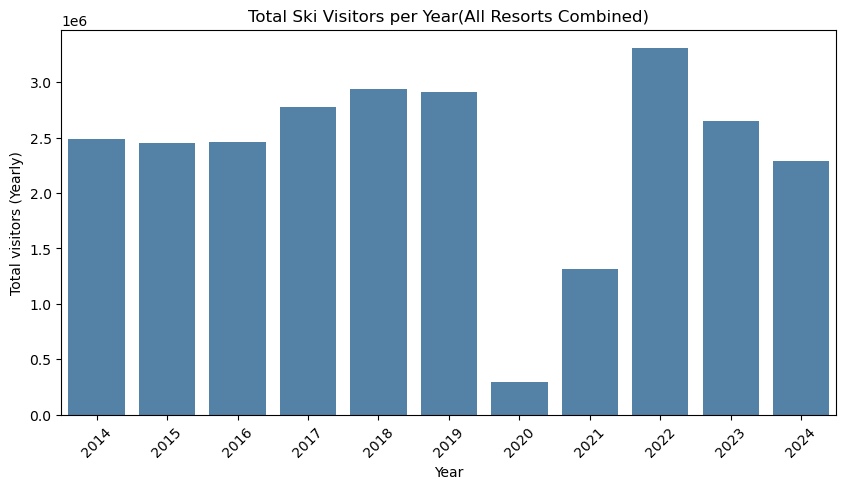

In [227]:
plt.figure(figsize=(10,5))
sns.barplot(data=annual_vis, x="Year", y="Visitors", color="steelblue")
plt.title("Total Ski Visitors per Year(All Resorts Combined)")
plt.ylabel("Total visitors (Yearly)")
plt.xticks(rotation=45)
plt.grid(False)   
plt.show()

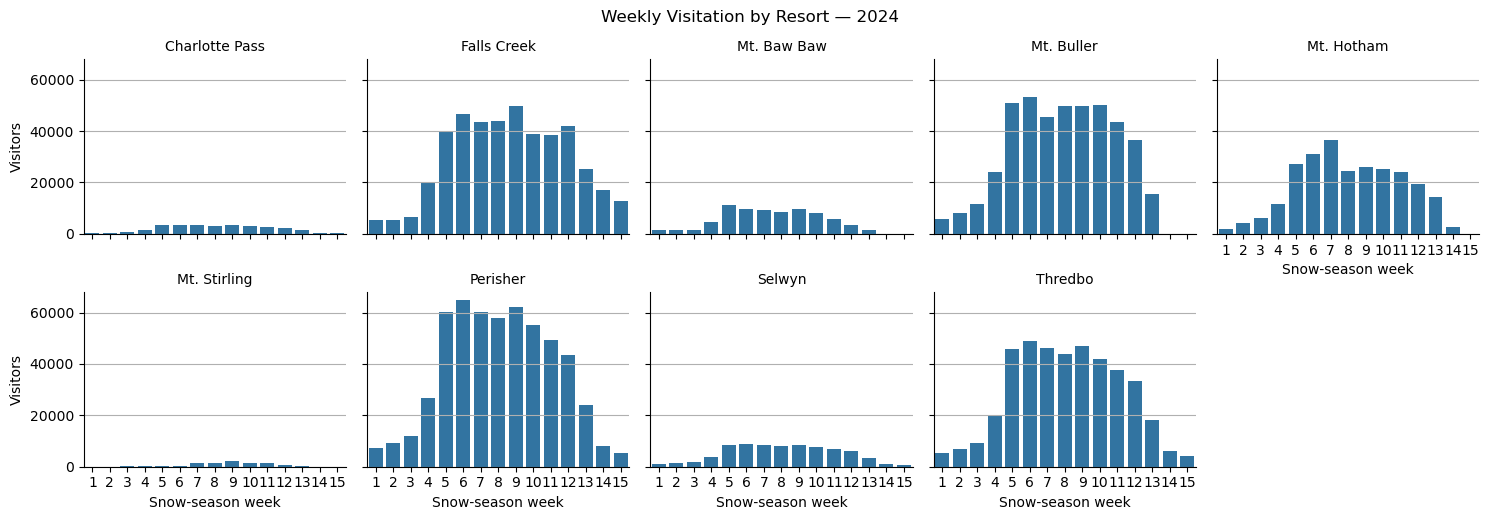

In [228]:
year_to_plot = 2024  # <-- change this

df_year = vis_long[vis_long["Year"] == year_to_plot].copy()

# sort resorts (optional)
resort_order = sorted(df_year["Resort"].unique())
df_year["Resort"] = pd.Categorical(df_year["Resort"], categories=resort_order, ordered=True)

# bar plots (histogram-like, one per resort)
g = sns.catplot(
    data=df_year,
    x="Week", y="Visitors",
    col="Resort",
    kind="bar",             # <--- bar instead of line
    col_wrap=5,             # 5 columns per row
    height=2.5, aspect=1.2,
    sharey=True, sharex=True
)

g.set_titles("{col_name}")
g.set_axis_labels("Snow-season week", "Visitors")
g.fig.suptitle(f"Weekly Visitation by Resort — {year_to_plot}", y=1.03)
plt.show()


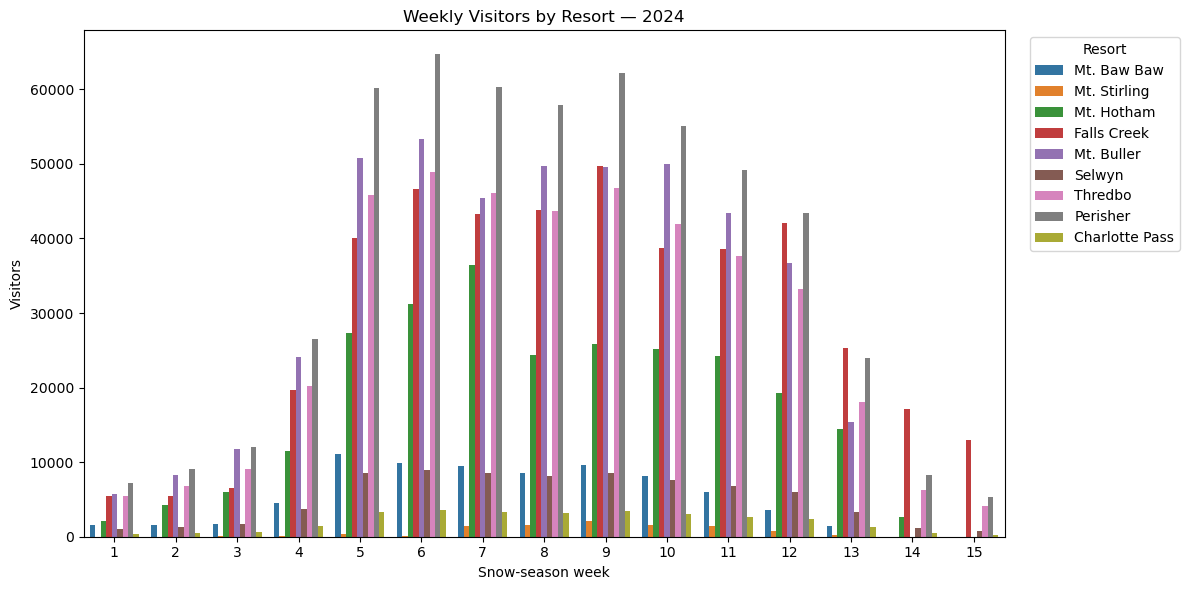

In [229]:
year_to_plot = 2024  # change as needed

# 1) filter + clean
df_year = (
    vis_long[vis_long["Year"] == year_to_plot]
    .dropna(subset=["Week","Resort","Visitors"])
    .copy()
)
df_year["Week"] = df_year["Week"].astype(int)

# fix order: weeks 1..15
week_order = list(range(1, 16))
df_year["Week"] = pd.Categorical(df_year["Week"], categories=week_order, ordered=True)

# 2) grouped bars (9 bars per week)
plt.figure(figsize=(12,6))
ax = sns.barplot(
    data=df_year,
    x="Week", y="Visitors",
    hue="Resort", dodge=True, estimator="sum"
)
ax.set_title(f"Weekly Visitors by Resort — {year_to_plot}")
ax.set_xlabel("Snow-season week"); ax.set_ylabel("Visitors")
ax.grid(False)  # remove horizontal lines
ax.legend(title="Resort", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


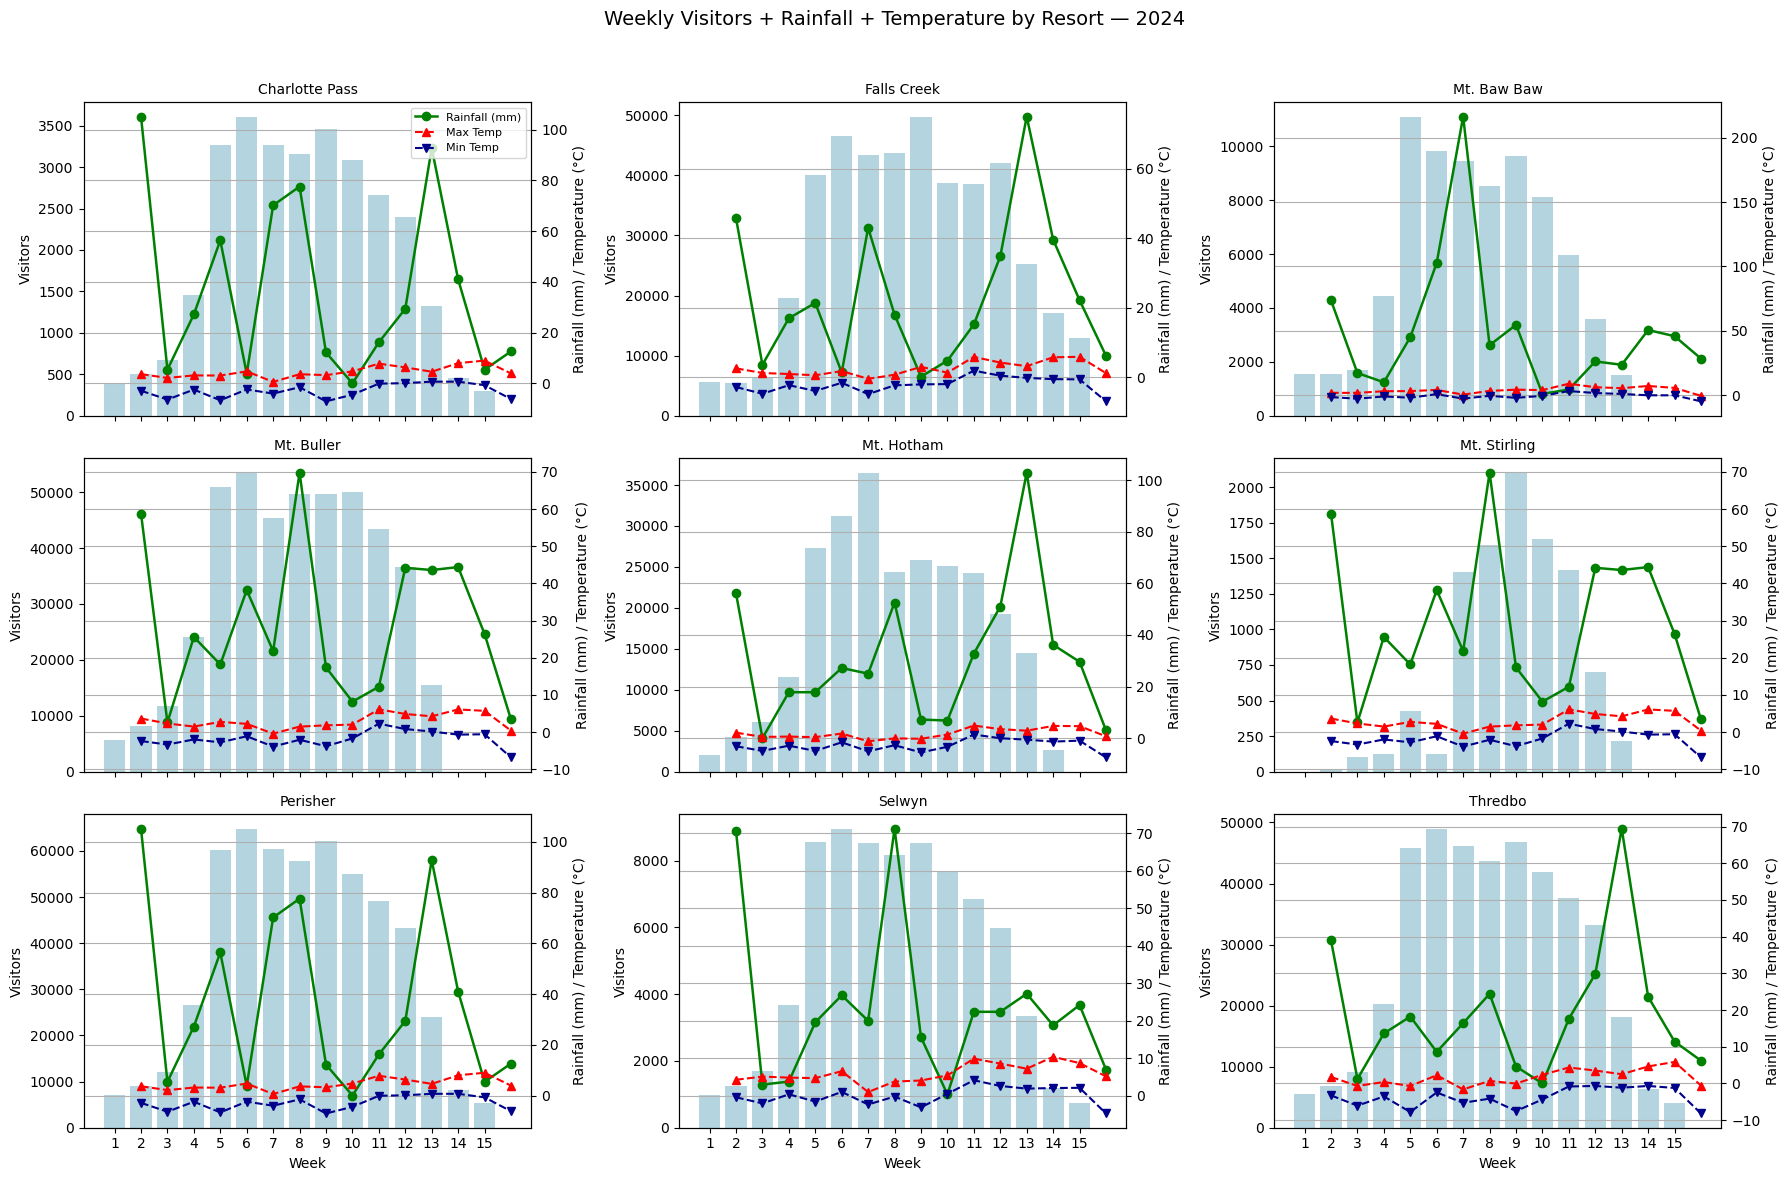

In [230]:
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

year_to_plot = 2024

# --- ensure clean types
vl = vis_long.dropna(subset=["Year","Week","Resort","Visitors"]).copy()
vl["Year"] = vl["Year"].astype(int)
vl["Week"] = vl["Week"].astype(int)

cl_by_stn = climate_weekly_by_station.copy()
cl_by_stn["Year"] = cl_by_stn["Year"].astype(int)
cl_by_stn["Week"] = cl_by_stn["Week"].astype(int)

# --- pick resorts present that also have a station mapping
resorts = sorted([r for r in vl["Resort"].unique() if r in RESORT_TO_STATION])

# --- layout
n = len(resorts)
ncols = 3
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 12), sharex=True)
axes = axes.flatten()

# --- precompute climate for the year
clim_year = cl_by_stn[cl_by_stn["Year"] == year_to_plot].copy()

# canonical week axis 1..15
wk_index = pd.DataFrame({"Week": list(range(1, 16))})

for i, resort in enumerate(resorts):
    ax1 = axes[i]
    stn = RESORT_TO_STATION[resort]

    # visitors for this resort/year
    df_r = (
        vl[(vl["Resort"] == resort) & (vl["Year"] == year_to_plot)]
        .groupby("Week", as_index=False)["Visitors"].sum()
        .merge(wk_index, on="Week", how="right")  # ensure all weeks present
        .fillna({"Visitors": 0})
        .sort_values("Week")
    )

    # climate (rainfall + temps) for this resort's station
    clim_r = (
        clim_year[clim_year["station_id"] == stn][["Week", "Rain_mm", "TempMax_C", "TempMin_C"]]
        .merge(wk_index, on="Week", how="right")
        .fillna({"Rain_mm": 0})
        .sort_values("Week")
    )

    # bars = visitors
    sns.barplot(data=df_r, x="Week", y="Visitors", color="lightblue", ax=ax1)
    ax1.set_title(resort, fontsize=10)
    ax1.set_xlabel("Week")
    ax1.set_ylabel("Visitors")
    ax1.grid(False)

    # climate lines on right axis
    ax2 = ax1.twinx()
    ax2.plot(clim_r["Week"], clim_r["Rain_mm"], color="green", marker="o", linewidth=1.8, label="Rainfall (mm)")
    ax2.plot(clim_r["Week"], clim_r["TempMax_C"], color="red", marker="^", linestyle="--", linewidth=1.5, label="Max Temp")
    ax2.plot(clim_r["Week"], clim_r["TempMin_C"], color="darkblue", marker="v", linestyle="--", linewidth=1.5, label="Min Temp")
    ax2.set_ylabel("Rainfall (mm) / Temperature (°C)")

    # only add legend once (top left subplot)
    if i == 0:
        ax2.legend(loc="upper right", fontsize=8)

# remove any unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle(f"Weekly Visitors + Rainfall + Temperature by Resort — {year_to_plot}", fontsize=14, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [231]:
df.columns

Index(['Year', 'Week', 'Ski Resort', 'visitors', 'visitors_lag1',
       'visitors_roll3', 'station_id', 'TempMax_C', 'TempMin_C', 'Rain_mm',
       'Average_snow_deepth_10years', 'SnowAvgDepth_cm_roll3', 'TempMean_C',
       'DiurnalRange_C', 'Freeze_flag', 'Cold_degree', 'Rain_log1p',
       'Rain_heavy', 'Cold_x_Rain', 'SnowDepth_cm', 'SnowDepth_log1p',
       'week_sin', 'week_cos', 'is_early', 'is_peak', 'is_late', 'State',
       'Distance_MEL_km', 'Distance_SYD_km', 'Distance_CAN_km',
       'Time_from_MEL', 'Time_from_SYD', 'Time_from_CAN',
       'has_public_transport', 'parking', 'lift', 'blue_slope', 'red_slope',
       'black_slope', 'cross-country', 'cross_country'],
      dtype='object')

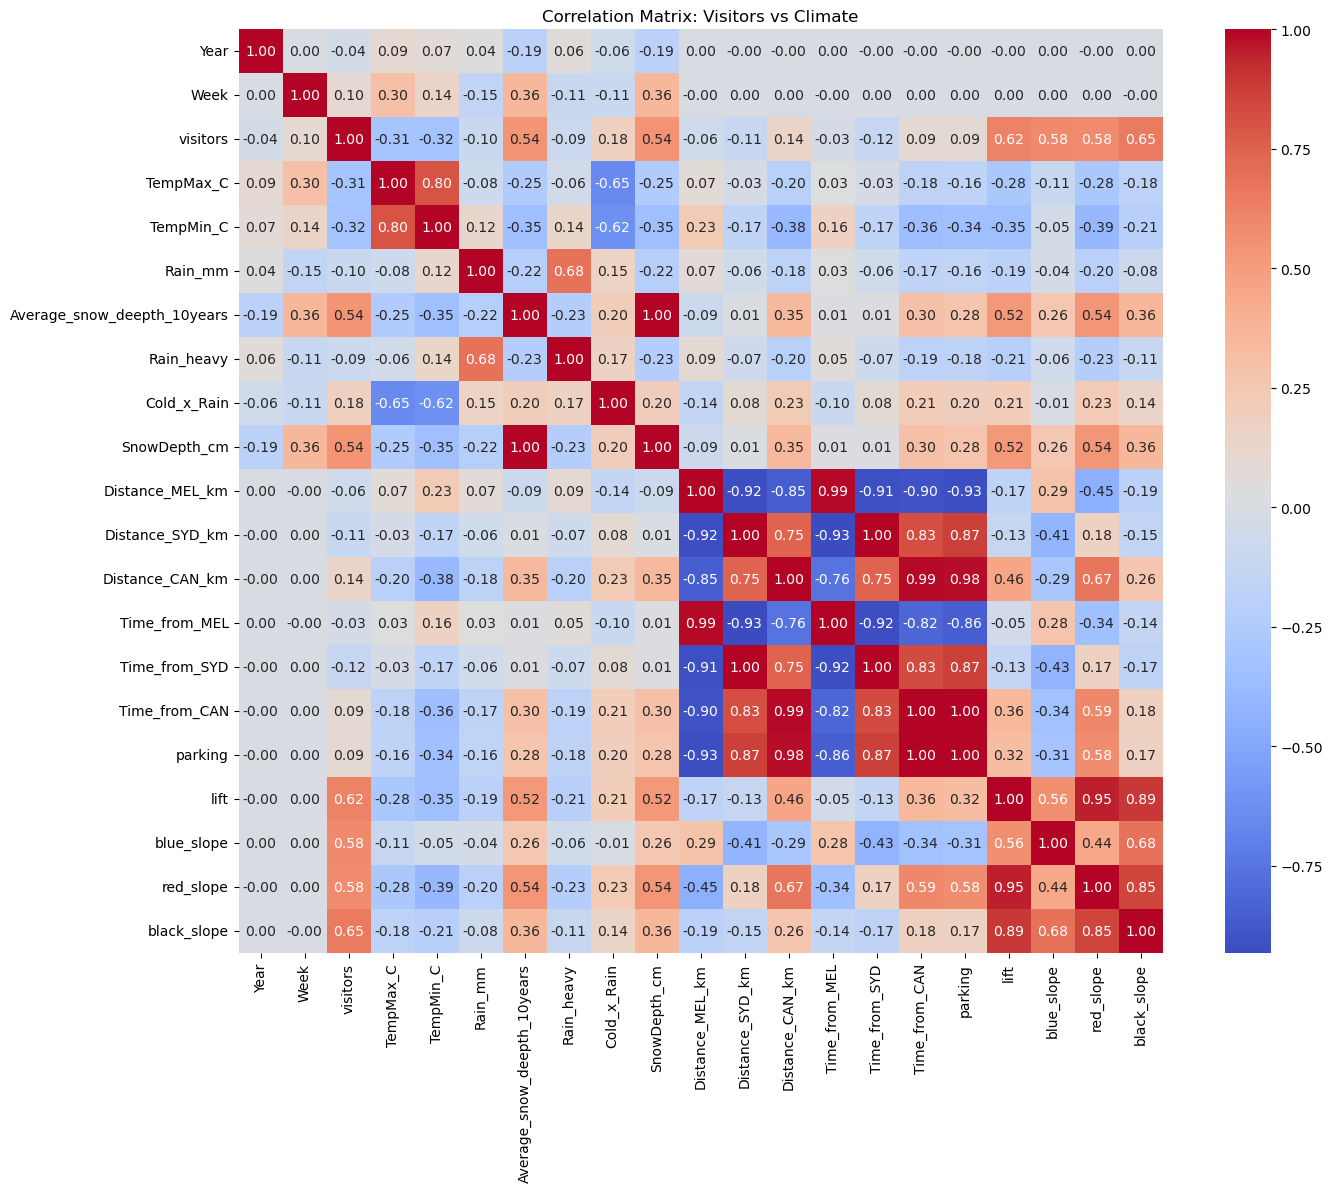

In [232]:
# 选择数值列做相关性分析
corr_cols = ['Year', 'Week', 'visitors', 'TempMax_C', 'TempMin_C', 'Rain_mm',
       'Average_snow_deepth_10years',
       'Rain_heavy', 'Cold_x_Rain', 'SnowDepth_cm',
       'Distance_MEL_km', 'Distance_SYD_km', 'Distance_CAN_km',
       'Time_from_MEL', 'Time_from_SYD', 'Time_from_CAN',
       'parking', 'lift', 'blue_slope', 'red_slope',
       'black_slope']
corr = df[corr_cols].corr()

plt.figure(figsize=(16,12))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix: Visitors vs Climate")
plt.grid(False)
plt.show()


# Modelling

In [233]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb


In [234]:
# Choose predictors
features = [
    "SnowDepth_cm","TempMean_C","TempMax_C","TempMin_C",
    "Rain_mm","Rain_heavy","Cold_x_Rain",
    "visitors_lag1","visitors_roll3",
    "Distance_MEL_km","Distance_SYD_km","Distance_CAN_km",
    "Time_MEL_hrs","Time_SYD_hrs","Time_CAN_hrs",
    "has_public_transport","week_sin","week_cos","is_early","is_peak","is_late"
]

# Filter existing ones (in case some aren’t in your df)
features = [c for c in features if c in df.columns]

X = df[features].fillna(0)   # impute missing with 0 (safe for trees)
y = df["visitors"]

# Example: random split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(X_train.shape, X_test.shape)

train_mask = df["Year"] < 2024
test_mask  = df["Year"] >= 2024

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test   = X[test_mask], y[test_mask]



(1188, 18) (297, 18)


In [235]:
# Predict everyone’s visitors as the training mean
y_pred_baseline = np.full_like(y_test, fill_value=y_train.mean(), dtype=float)

rmse_base = mean_squared_error(y_test, y_pred_baseline, squared=False)
r2_base   = r2_score(y_test, y_pred_baseline)

print(f"Baseline (mean) → RMSE: {rmse_base:.2f}, R²: {r2_base:.3f}")


Baseline (mean) → RMSE: 18869.37, R²: -0.001


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [236]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_lin = linreg.predict(X_test)

rmse_lin = mean_squared_error(y_test, y_pred_lin, squared=False)
r2_lin   = r2_score(y_test, y_pred_lin)

print(f"Linear Regression → RMSE: {rmse_lin:.2f}, R²: {r2_lin:.3f}")


Linear Regression → RMSE: 5485.29, R²: 0.915


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [237]:
model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

y_pred_xgb = model.predict(X_test)

rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
r2_xgb   = r2_score(y_test, y_pred_xgb)

print(f"XGBoost → RMSE: {rmse_xgb:.2f}, R²: {r2_xgb:.3f}")


XGBoost → RMSE: 4617.70, R²: 0.940


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


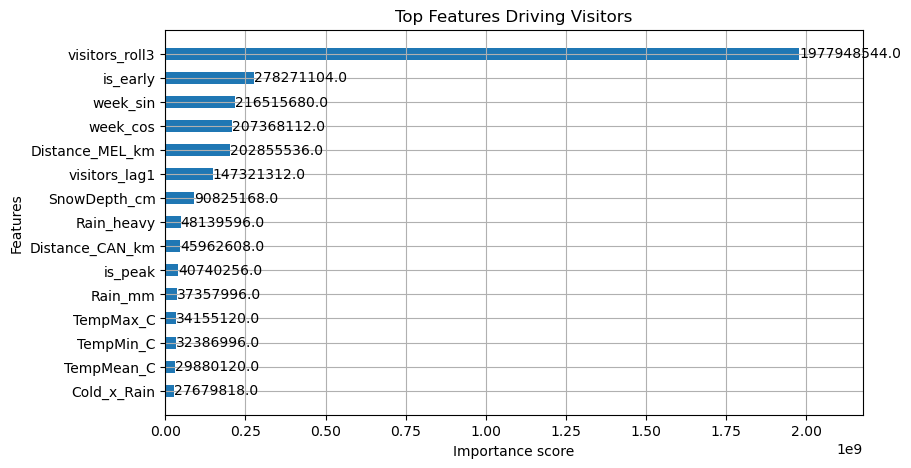

In [238]:
xgb.plot_importance(model, importance_type="gain", max_num_features=15, height=0.5)
plt.title("Top Features Driving Visitors")
plt.show()


# Positioning and Clustering

In [239]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

feat_df = pd.read_csv("data/ticket_lift_fees.csv")
new_df = pd.merge(cleaned_dist,feat_df, on="Ski Resort")
df = pd.merge(new_df,distance)

feat_cols = [
    "Time_from_MEL", "Time_from_SYD", "Time_from_CAN",
    "parking","lift",
    "blue_slope","red_slope","black_slope"
]

# mean across all weeks/years per resort
X_resort = new_df.groupby("Ski Resort")[feat_cols].mean().fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resort)


In [240]:
n_samples = X_resort.shape[0]
max_k = max(2, n_samples)          # upper bound for k
K_range = range(2, max_k + 1)      # e.g., if n_samples=5 -> k = 2..5

inertia = []
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)


In [241]:
k = min(3, n_samples)              # choose 2 or 3 for 5 resorts
kmeans = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
X_resort["Cluster"] = kmeans.labels_

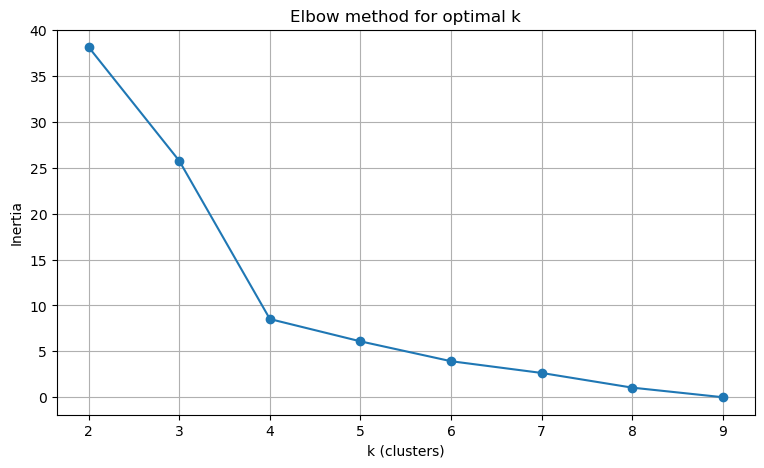

,Time_from_MEL,Time_from_SYD,Time_from_CAN,parking,lift,blue_slope,red_slope,black_slope,Cluster
Ski Resort,,,,,,,,,
Charlotte Pass,7.70,5.80,2.80,29.0,175.0,1.0,8.0,1.0,2
Falls Creek,4.83,7.87,5.62,67.0,243.0,6.0,35.0,8.0,0
Mount Baw Baw,2.83,10.83,7.73,67.0,89.0,7.0,3.0,0.0,0
Mount Buller,3.25,8.37,6.12,67.0,234.0,9.5,21.4,16.6,0
Mount Hotham,4.62,8.07,5.82,67.0,243.0,6.0,12.0,12.0,0


In [242]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

n_samples = X_resort.shape[0]
max_k = max(2, n_samples)          # upper bound for k
K_range = range(2, max_k + 1)      # e.g., if n_samples=5 -> k = 2..5

inertia = []
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)


plt.plot(K_range, inertia, marker="o")
plt.title("Elbow method for optimal k")
plt.xlabel("k (clusters)")
plt.ylabel("Inertia")
plt.show()

# Fit final model (choose k based on elbow)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

X_resort["Cluster"] = clusters
X_resort.head()


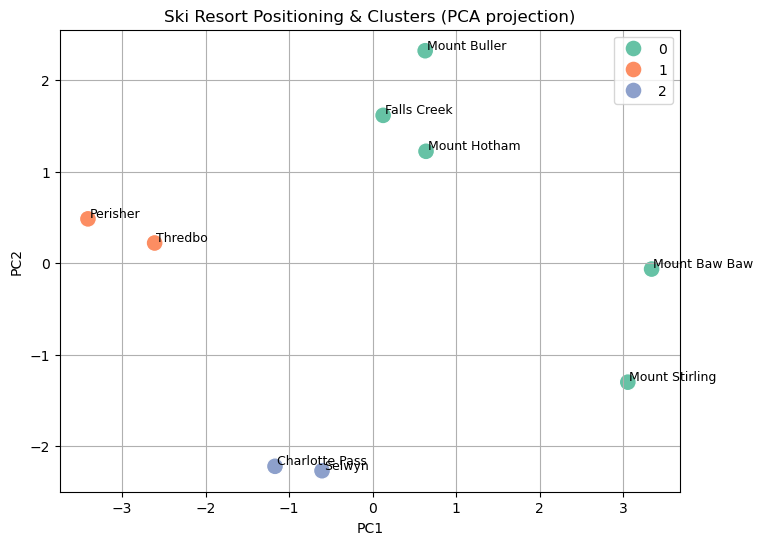

In [243]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
coords = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=coords[:,0], y=coords[:,1], hue=clusters, palette="Set2", s=150)

for i, name in enumerate(X_resort.index):
    plt.text(coords[i,0]+0.02, coords[i,1]+0.02, name, fontsize=9)

plt.title("Ski Resort Positioning & Clusters (PCA projection)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()
